In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
import dask
import dask.array as da
from PIL import Image
from skimage.transform import resize
from matplotlib import pyplot as plt
import scipy
%matplotlib inline
np.set_printoptions(threshold=10000, linewidth=32)

In [27]:
masks = np.asarray(sorted(glob.glob("/home/skyolia/JupyterProjects/data/BASE-CYTO/images etiquetées/*.bmp")))
images = np.asarray(sorted(glob.glob("/home/skyolia/JupyterProjects/data/BASE-CYTO/images originales/*.bmp")))

In [28]:
rnd = np.random.choice(87, 61, False)
#train_x, train_y = x[train_idx], y[train_idx]

splitter = np.isin(np.arange(87), rnd, True)
train, test = np.where(splitter)[0], np.where(~splitter)[0]

np.sum(splitter), train, test

(61, array([ 1,  2,  4,  5,  6,  8,
         9, 10, 12, 13, 14, 15,
        17, 18, 20, 21, 23, 24,
        25, 26, 27, 28, 29, 30,
        31, 32, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44,
        45, 47, 48, 54, 55, 56,
        58, 59, 61, 62, 64, 67,
        68, 69, 70, 72, 74, 75,
        76, 77, 78, 82, 83, 84,
        85]), array([ 0,  3,  7, 11, 16, 19,
        22, 33, 34, 46, 49, 50,
        51, 52, 53, 57, 60, 63,
        65, 66, 71, 73, 79, 80,
        81, 86]))

In [41]:
def extract_patch_single_image(i, crop_size):
    #i = i[:, :, np.newaxis] if i.ndim == 2 else i
    crops = []
    print(i.shape)
    height, width = i.shape[0], i.shape[1]
    for h in range(0, height - crop_size[0], 10):
        for w in range(0, width - crop_size[1], 10):
            crops.append(i[h:h+crop_size[0], w:w+crop_size[1], :])
    return np.asarray(crops)

def load_save(path, mode, crop_size, new_shape=None):
    #image = Image.open(path).convert(mode)
    image = scipy.ndimage.imread(path, mode=mode)
    image = np.asarray(image)#/255.0
    image = image[:, :, np.newaxis] if image.ndim == 2 else image
    #image = extract_patch_single_image(image, crop_size) if crop_size else image
    image = resize(image, new_shape, preserve_range = True) if new_shape else image
    return image#.astype(int)

def data_processing(data_paths, crop_size, new_shape, mode, chunk, stack=False):
    x = []
    for i in data_paths:
        image = dask.delayed(load_save)(i, mode, crop_size, new_shape=None)
        image = image[np.newaxis, :, :, :]
        x.append(da.from_delayed(image, new_shape, dtype=int))
    res = da.stack(x, axis=0).rechunk(chunk) if stack else da.concatenate(x, axis=0).rechunk(chunk)
    return res

train_x = data_processing(images[train], (32, 32), (1, 768, 1024, 3), 'RGB', (1, 768, 1024, 3), False)
train_y = data_processing(masks[train], (32, 32), (1, 768, 1024, 1), 'L', (1, 768, 1024, 1), False)
colored_train_y = data_processing(masks[train], (32, 32), (1, 768, 1024, 3), 'RGB', (1, 768, 1024, 3), False)
train_x = data_processing(images[train], (32, 32), (1, 768, 1024, 3), 'RGB', (1, 768, 1024, 3), False)
train_y = data_processing(masks[train], (32, 32), (1, 768, 1024, 1), 'L', (1, 768, 1024, 1), False)
colored_train_y = data_processing(masks[train], (32, 32), (1, 768, 1024, 3), 'RGB', (1, 768, 1024, 3), False)
train_x, train_y, colored_train_y, test_x, test_y, colored_test_y

(dask.array<concatenate, shape=(61, 768, 1024, 3), dtype=int64, chunksize=(1, 768, 1024, 3)>,
 dask.array<concatenate, shape=(61, 768, 1024, 1), dtype=int64, chunksize=(1, 768, 1024, 1)>,
 dask.array<concatenate, shape=(61, 768, 1024, 3), dtype=int64, chunksize=(1, 768, 1024, 3)>,
 dask.array<concatenate, shape=(26, 768, 1024, 3), dtype=int64, chunksize=(1, 768, 1024, 3)>,
 dask.array<concatenate, shape=(26, 768, 1024, 1), dtype=int64, chunksize=(1, 768, 1024, 1)>,
 dask.array<concatenate, shape=(26, 768, 1024, 3), dtype=int64, chunksize=(1, 768, 1024, 3)>)

In [42]:
rows, columns = 3, 3
idx_0 = np.random.choice(61, columns * rows, False)
#[73691, 298449, 108763, 299316, 217335,  39151, 255325, 377859, 230124]
idx_0

array([29, 32, 18, 30, 49, 53,
       33,  5, 22])

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


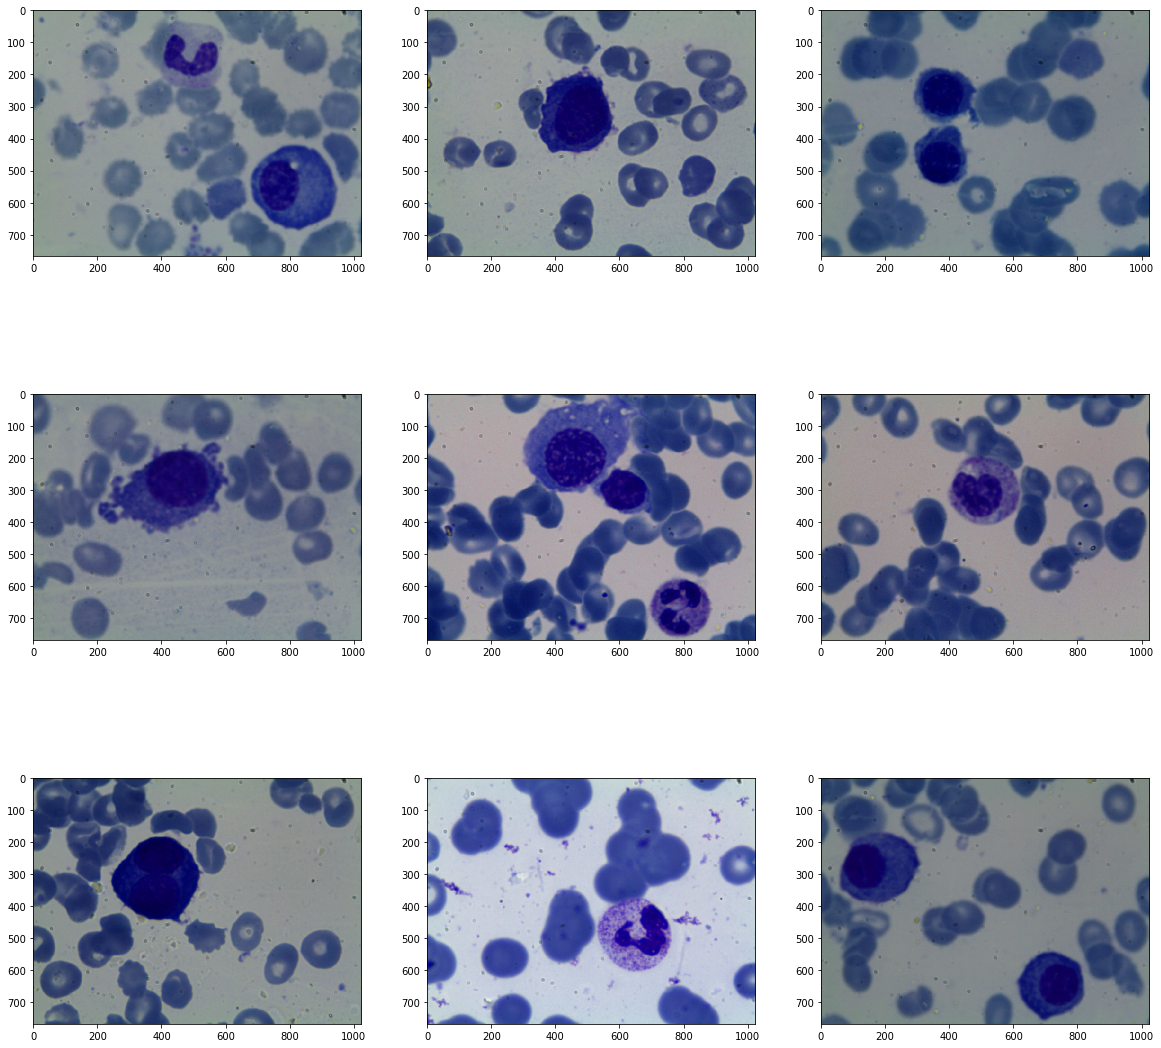

In [55]:
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_x[idx_0[i-1]].compute(), cmap=plt.get_cmap('gray'))
plt.show()

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


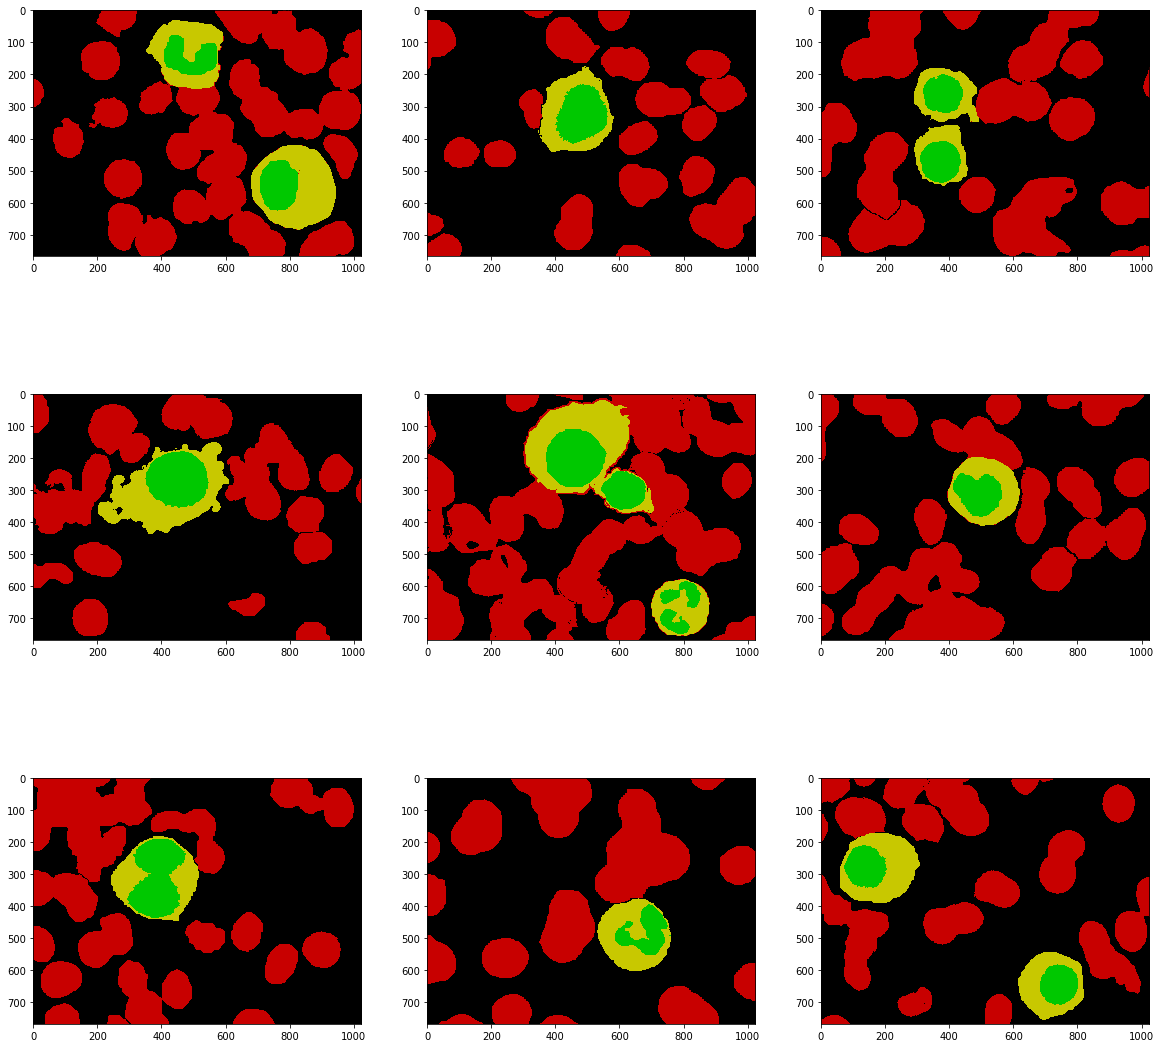

In [56]:
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(colored_train_y[idx_0[i-1]].compute(), cmap=plt.get_cmap('gray'))
plt.show()

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)
(768, 1024, 1)


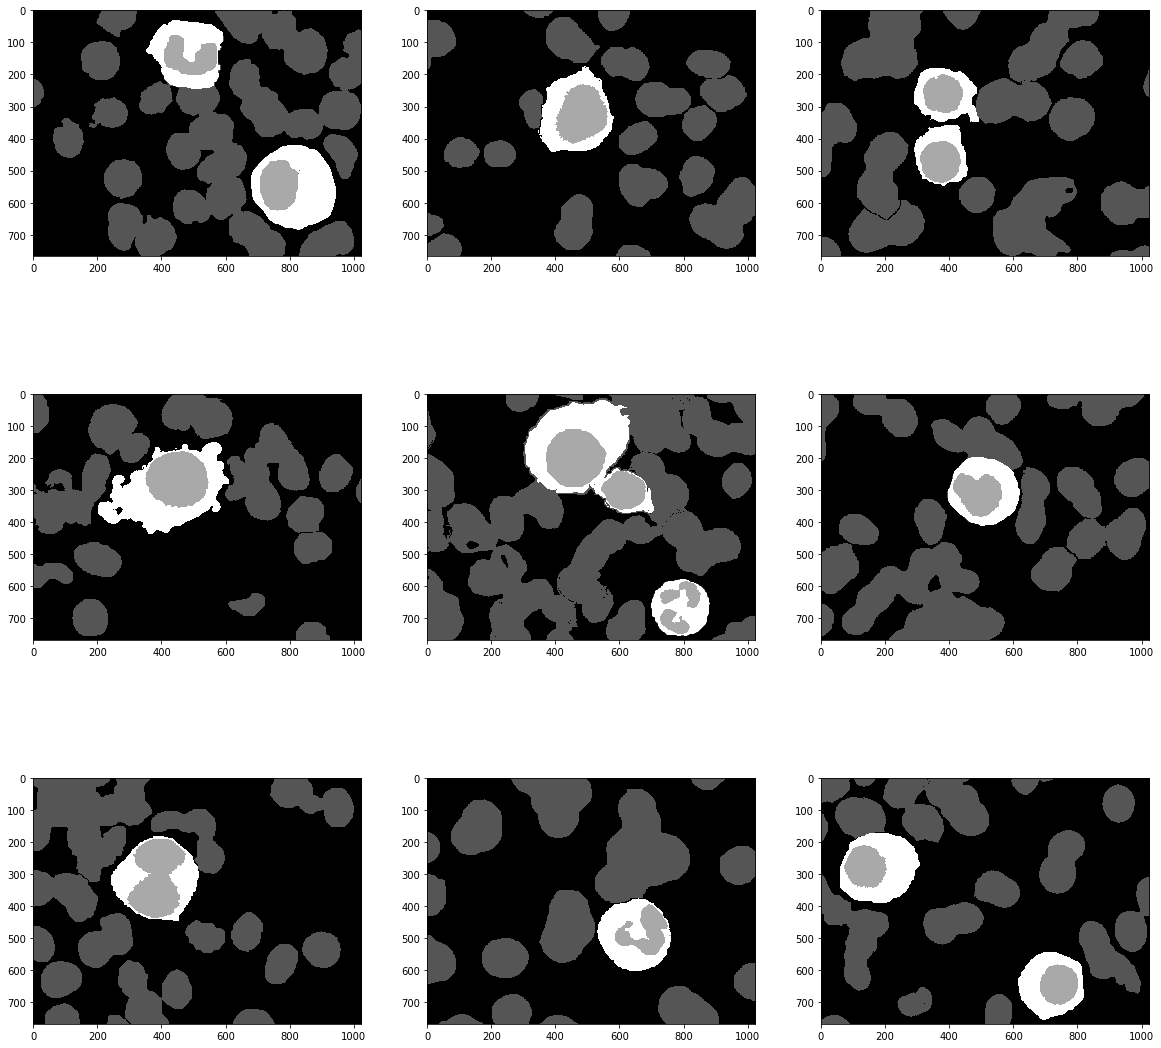

In [57]:
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    print(train_y[idx_0[i-1]].compute().shape)
    plt.imshow(np.squeeze(train_y[idx_0[i-1]].compute()), cmap=plt.get_cmap('gray'))
plt.show()

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


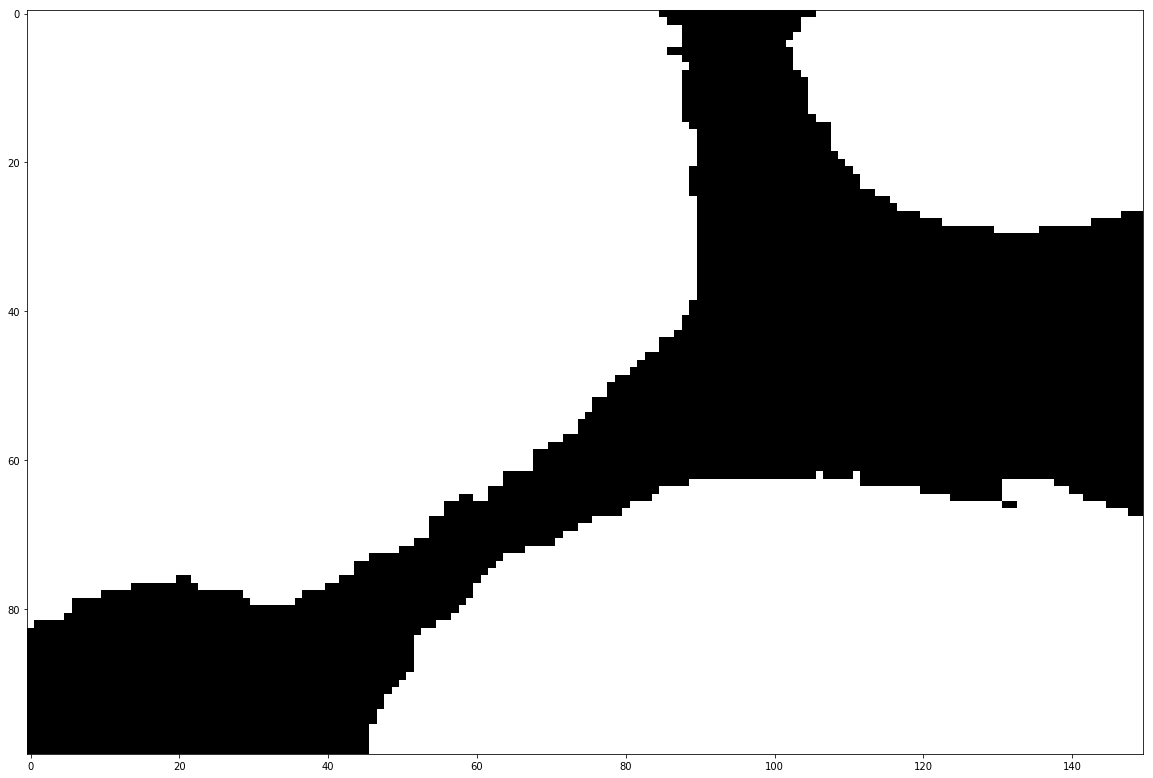

[[59 59 59 ... 59 59 59]
 [59 59 59 ... 59 59 59]
 [59 59 59 ... 59 59 59]
 ...
 [ 0  0  0 ... 59 59 59]
 [ 0  0  0 ... 59 59 59]
 [ 0  0  0 ... 59 59 59]]


In [65]:
to_save = np.squeeze(train_y[idx_0[8], 0:100, 0:150, :].compute())
fig=plt.figure(figsize=(20, 20))
k = 1
plt.imshow(to_save, cmap=plt.get_cmap('gray'))
plt.show()
print(to_save)
im = Image.fromarray(to_save)
#im = im.convert('RGB')
im.save("your_file.jpeg")

/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


IndexError: too many indices for array

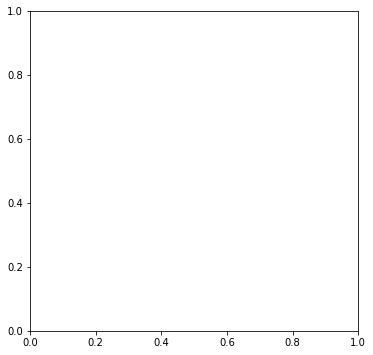

In [15]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 3
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_x[i-1].compute(), cmap=plt.get_cmap('gray'))
plt.show()